# Final Project

Authors: Guillem Llados, Marc Illa, Toni Isart, Martí Grau


Initialization of the environment.

In [1]:
import numpy as np
np.random.seed(1) 
import torch
import torch.optim as optim
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib
import random
%matplotlib inline
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Exercise 1: Convolutional Autoencoder
- Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.

- Implement a convolutional autoencoder (with separate Encoder and Decoder modules).

- Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.

- Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.

- Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.

- Generate 5 new images by injecting random values as input to the decoder. Show them.




*Let's first define the parameters needed for the training:*

In [0]:
BATCH_SIZE = 128

hparams = {
    'train_batch_size':BATCH_SIZE,
    'num_epochs':20, 
    'num_epochs2':10, 
    'val_batch_size':BATCH_SIZE,
    'learning_rate':1e-3
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion  = nn.MSELoss()

--------------
- Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.

*Get datasets, convert to tensors and normalize*

In [3]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,)) 
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

0it [00:00, ?it/s]

9920512it [00:00, 10170928.10it/s]                           


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 136353.31it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2240367.39it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 51384.58it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


*Let's split the training data in training and validation with random_split function*

In [0]:
train_size = int(0.95 * len(mnist_trainset))
validation_size = len(mnist_trainset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(mnist_trainset, [train_size, validation_size])

*Load the data to a train, validation and test loaders.*

In [0]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=BATCH_SIZE, 
    shuffle=False)

- Implement a convolutional autoencoder (with separate Encoder and Decoder modules).


### Encoder module:

In this section we implement the Encoder class, where the input will be an MNIST image of 28x28 with one only channel, and the output is parameter called 'bottleneckSize', used to analyise the influence of different values of the output of the Encoder.

In [0]:
# Encoder class
class Encoder(nn.Module):
    def __init__(self, bottleneckSize):
        super(Encoder, self).__init__()
        self.enc=nn.Sequential(
            nn.Conv2d(1,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(5*5*64,800),
            nn.ReLU(),
            nn.Linear(800,bottleneckSize),
            nn.ReLU()       
            )
    # encode 
    def forward (self, x):
        x=self.enc(x)
        return x

### Decoder module:

Here is defined the Decoder class, where the input will be the 'bottleneckSize' parameter introduced in the previous module and the output is a map of 28x28 as a reconstruction of the first input image of the Autoencoder.

In [0]:
# Decoder class
class Decoder(nn.Module):
    def __init__(self, bottleneckSize):
        super(Decoder, self).__init__() 

        # Decoder params
        self.mlp=nn.Sequential(
            nn.Linear(bottleneckSize,800),
            nn.ReLU(),
            nn.Linear(800,5*5*64),
            nn.ReLU())
        self.sigmoid              = nn.Sigmoid()
        self.firstTransConvLayer  = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1)        
        self.upsampling           = nn.UpsamplingBilinear2d(scale_factor=2)
        self.relu                 = nn.ReLU()
        self.secondTransConvLayer = nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)
        self.lastconv             = nn.Conv2d(1,1,1)
        
    # decode
    def forward(self, x):
        x = self.mlp(x)
        x = x.view([x.shape[0],64,5,5])
        x = self.upsampling(self.firstTransConvLayer(x))
        x = self.relu(x)
        x = self.upsampling(self.secondTransConvLayer(x))
        x = nn.Tanh()(self.lastconv(x))

        return x 

### Module Autoencoder (Encoder + Decoder)
Here we define a class autoencoder which will contain both modules

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self, bottleNeckSize):
        super(AutoEncoder,self).__init__() 
        self.encoding = Encoder(bottleneckSize = bottleNeckSize)
        self.decoding = Decoder(bottleneckSize = bottleNeckSize)
        self.bottleneckSize = bottleNeckSize

    def forward(self, x):
        x = self.encoding(x)
        x = self.decoding(x)
        return x
    def get_bottleneckSize(self):
        return self.bottleneckSize

- Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.


*Now we define a function to perform the training over one epoch:*

In [0]:
def train_epoch(train_loader, model, optimizer, criterion, hparams, epoch):
    # Activate the train=True flag inside the model (network)
    model.train()
    device = hparams['device']
    losses = []    
    for batch_idx, (inputImage, label) in enumerate(train_loader): 
        optimizer.zero_grad()
        # get the inputs to device
        inputImage = inputImage.to(device)
        # forward
        outputImage = model(inputImage)
        # loss (difference between input and output)
        loss = criterion(outputImage, inputImage)
        # backprop
        loss.backward()
        optimizer.step()
        # store loss as we will return them
        losses.append(loss.item())      
    return losses

*Now a function for computing the validation loss over one epoch:*

In [0]:
def eval_epoch(val_loader, model, criterion, hparams):
    # Set train flag to false
    model.eval()
    device = hparams['device']
    losses = [] 
    # set all the requires_grad flag to false (we don't compute gradients)
    with torch.no_grad():
        for batch_idx, (inputImage, label) in enumerate(val_loader):
            # get the inputs to device
            inputImage = inputImage.to(device)
            # forward
            outputImage = model.forward(inputImage)
            # loss (difference between input and output)
            loss = criterion(outputImage, inputImage)
            # store loss as we will return the mean of the losses in this epoch (and then will plot them)
            losses.append(loss.item())
    return np.mean(losses)

*Finally, the function to train our network and plot the loss after each epoch*

In [0]:
def train_net(train_set,model, optimizer, num_epochs, title, plot=True):
    train_losses = []
    validation_losses = []
    model.to(hparams['device'])
    epoch_pos = []
    epoch_labels = []
    
    # train over the number of epochs, validate after each epoch
    for epoch in range(1, num_epochs + 1):
        train_loss      = train_epoch(train_set, model, optimizer, criterion, hparams, epoch)
        validation_loss = eval_epoch(validation_loader, model, criterion, hparams)
        train_losses.extend(train_loss)
        validation_losses.append(validation_loss)
        if len(epoch_pos)>0:
          epoch_pos.append(len(train_loss)+epoch_pos[len(epoch_pos)-1])
        else:
          epoch_pos.append(len(train_loss))
        epoch_labels.append(str(epoch))
        print('Epoch {}: Train loss {}, Val loss {}'.format(epoch,np.mean(train_loss),validation_loss))
    test_loss = eval_epoch(test_loader, model, criterion, hparams)
    losses = {'Model_bottlenecksize':model.get_bottleneckSize(),'tr_losses':train_losses, 'te_losses':validation_losses, 'ts_loss':test_loss, 'epoch_pos':epoch_pos, 'epoch_labels':epoch_labels}
    print('Test loss {}'.format(test_loss))

    if plot:
      plt.figure(figsize=(10, 8))
      plt.title(title)
      plt.xlabel('Epoch')
      plt.ylabel('MSE')
      plt.plot(train_losses, label='train')
      plt.plot(epoch_pos,validation_losses, label='eval')
      plt.xticks(epoch_pos,epoch_labels)
      plt.legend()
    return losses  


*We can now train the network:*

In [12]:
model_log=[]

model2 = AutoEncoder(bottleNeckSize=2)
model2.to(hparams['device'])
optimizer  = optim.Adam(model2.parameters(), hparams['learning_rate'])
model_log.append(train_net(train_loader, model2, optimizer, hparams['num_epochs'], title= 'BottleNeck Size 2', plot=False))

model5 = AutoEncoder(bottleNeckSize=5)
model5.to(hparams['device'])
optimizer  = optim.Adam(model5.parameters(), hparams['learning_rate'])
model_log.append(train_net(train_loader, model5, optimizer, hparams['num_epochs'], title= 'BottleNeck Size 5', plot=False))

model10 = AutoEncoder(bottleNeckSize=10)
model10.to(hparams['device'])
optimizer  = optim.Adam(model10.parameters(), hparams['learning_rate'])
model_log.append(train_net(train_loader, model10, optimizer, hparams['num_epochs'], title= 'BottleNeck Size 10', plot=False))




Epoch 1: Train loss 0.7175670046977398, Val loss 0.7120674500862757
Epoch 2: Train loss 0.7129145185776355, Val loss 0.7111597135663033
Epoch 3: Train loss 0.7127432499765816, Val loss 0.7109557837247849
Epoch 4: Train loss 0.7123771972720399, Val loss 0.7102254976828893
Epoch 5: Train loss 0.7122249565851528, Val loss 0.7109889735778173
Epoch 6: Train loss 0.7122493101609662, Val loss 0.7100954428315163
Epoch 7: Train loss 0.7121233674175537, Val loss 0.7101921439170837
Epoch 8: Train loss 0.712082002462293, Val loss 0.7099080383777618
Epoch 9: Train loss 0.7122001955327432, Val loss 0.7099002028505007
Epoch 10: Train loss 0.7120269895134486, Val loss 0.7098478699723879
Epoch 11: Train loss 0.7119952740957919, Val loss 0.709831011792024
Epoch 12: Train loss 0.7118928787954185, Val loss 0.7098859076698621
Epoch 13: Train loss 0.7118728061962555, Val loss 0.7097982987761497
Epoch 14: Train loss 0.7118480864394406, Val loss 0.7096389730771383
Epoch 15: Train loss 0.7118951904132227, Val 

Plot all trained networks together:

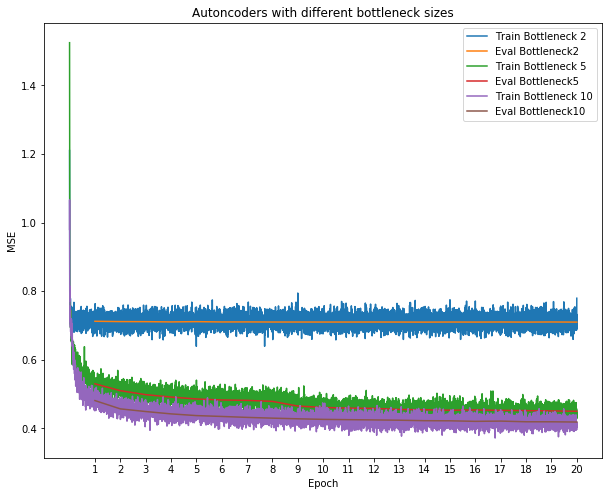

In [13]:
plt.figure(figsize=(10, 8))
plt.title('Autoncoders with different bottleneck sizes')
plt.xlabel('Epoch')
plt.ylabel('MSE')
bott=[2,5,10]
for k in range (0,len(bott)):
  plt.plot(model_log[k]['tr_losses'], label='Train Bottleneck '+str(bott[k]))
  plt.plot(model_log[k]['epoch_pos'],model_log[k]['te_losses'], label='Eval Bottleneck' + str(bott[k]))
plt.xticks(model_log[k]['epoch_pos'],model_log[k]['epoch_labels'])
plt.legend()

At this point we must save a checkpoint of our model to reuse it in the following exercise:

In [0]:
path='/content/gdrive/My Drive/'
torch.save(model2.state_dict(), f'{path}model2.pt')
torch.save(model5.state_dict(), f'{path}model5.pt')
torch.save(model10.state_dict(), f'{path}model10.pt')

In [15]:
path='/content/gdrive/My Drive/'
model2_2 = AutoEncoder(bottleNeckSize=2)
model2_2.load_state_dict(torch.load(f'{path}model2.pt'))

model5_2 = AutoEncoder(bottleNeckSize=5)
model5_2.load_state_dict(torch.load(f'{path}model5.pt'))

model10_2 = AutoEncoder(bottleNeckSize=10)
model10_2.load_state_dict(torch.load(f'{path}model10.pt'))


<All keys matched successfully>

- Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.


*Function for counting the # of params of a model:*

In [0]:
def model_params(model):
    # from: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [17]:
#create table
import pandas as pd
data=[('Model 1 Bottleneck size = 2',model_log[0]['te_losses'][-1],model_log[0]['ts_loss'],model_params(model2)),
      ('Model 2 Bottleneck size = 5',model_log[1]['te_losses'][-1],model_log[1]['ts_loss'],model_params(model5)),
      ('Model 3 Bottleneck size = 10',model_log[2]['te_losses'][-1],model_log[2]['ts_loss'],model_params(model10))]
df=pd.DataFrame(data,columns=['model','mse_validation', 'mse_test', 'parameters'])
df

,model,mse_validation,mse_test,parameters
0,Model 1 Bottleneck size = 2,0.709642,0.715450,2603973
1,Model 2 Bottleneck size = 5,0.449550,0.460032,2608776
2,Model 3 Bottleneck size = 10,0.418220,0.428263,2616781


- Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.


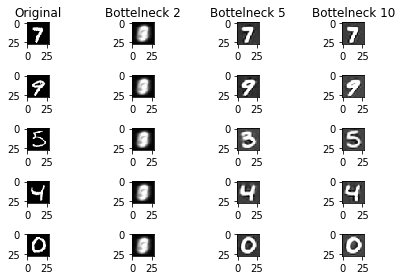

In [18]:
#Choose 5 random images 
device = hparams['device']
# define an iterator through the test images
iter_ = iter(test_loader)
# get a batch of images
bimg, _ = next(iter_)
# get rid off one dimention (matrix instead of tensor)
allimgs=bimg.squeeze(1).data.numpy()
# get 5 random images
imgs=random.sample(range(0,allimgs.shape[0]), 5)
inimg=[]
outimg=[]
f, axarr = plt.subplots(5, 4)
models = [model2,model5,model10]

cols = ['Original','Bottelneck 2','Bottelneck 5','Bottelneck 10']

# display the title of the column
for ax, col in zip(axarr[0], cols):
    ax.set_title(col)

# iterate through 5 images
for k in range(0,5):
  inimg.append(allimgs[imgs[k]])
  inputImage = bimg[imgs[k]].to(device)
  inputImage = inputImage.unsqueeze(0)
  # show original image
  axarr[k,0].imshow(allimgs[imgs[k]],cmap='gray')
  
  # iterate through the 3 models
  for i in range(0,3):
    output = models[i].forward(inputImage)
    outputImage = output.cpu()
    outimg.append(outputImage.squeeze(1).data.numpy())
    axarr[k,i+1].imshow(outputImage.squeeze(1).data.numpy()[0,:,:],cmap='gray')

# arrange plot layout    
plt.tight_layout()
plt.show()      





- Generate 5 new images by injecting random values as input to the decoder. Show them.

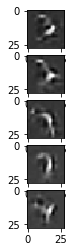

In [19]:
decoder = model10.decoding
_, axarr = plt.subplots(5)
for k in range(0,5):  
  inputImage=torch.randn(1, 10)
  inputImage = inputImage.to(device)
  output=decoder.forward(inputImage)
  outputImage = output.cpu()
  axarr[k].imshow(outputImage.squeeze(1).data.numpy()[0,:,:],cmap='gray')
plt.show()

# Exercise 2: Transfer Learning
- Select a subset of 100 images and their associated labels from the MNIST training data.
- Select one of the previously trained autoencoders.
- Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
- Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.
- Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
- From scratch: train the model on the 100 samples without reusing the decoder weights at all.
- Show the accuracy of the four models on the MNIST test set in a table.


- Select a subset of 100 images and their associated labels from the MNIST training data.



In [0]:
NUM_TRAIN_IMG = 100  # Number of image to retrain the net
NUM_OUTPUTS = 10      # Number of classes we want to classify
BATCH_SIZE = 10

small_train_size = NUM_TRAIN_IMG
other_train_data = len(mnist_trainset) - small_train_size

small_train_dataset, other = torch.utils.data.random_split(mnist_trainset, [NUM_TRAIN_IMG, other_train_data])

small_train_loader = torch.utils.data.DataLoader(
    small_train_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True)

- Select one of the previously trained autoencoders.

In [21]:
path='/content/gdrive/My Drive/'
bottleNeckSize = 10
model10_2 = AutoEncoder(bottleNeckSize)
model10_2.load_state_dict(torch.load(f'{path}model10.pt'))# Here we take all the full autoencoder


<All keys matched successfully>

-------------------
## Pre-Training:

- Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

At this point we will need to reuse the first part of the Autoencoder model (Encoder) to use it as a feature_extractor ***using the pre-trained weigths as initial point*** to train our classifier. 

This means that we will stick a densely-connected classifier at the end of the Encoder in order to classify between the classes 0 to 9. (10 classes = 10 outputs)

Here we select the encoder part with the previous trained wights

In [0]:
pretrained_encoder = model10_2.encoding #Here we only take the encoder part

In the following cell, we define the classification module

In [0]:
classifier_model = nn.Sequential( 
                nn.Linear(bottleNeckSize,250),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(250,NUM_OUTPUTS),
                nn.ReLU(),
                nn.LogSoftmax()
              )

Now we must create another training net function and epoch net function for this specific problem.

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability for the whole batch
  # compute the element-wise equality between pred and label_batch and sum all the results
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch_classifier(train_loader, enc_model, classif_model, optimizer, criterion, hparams, epoch):
  device = hparams['device']
  losses = []
  # Activate the train=True flag inside the models 
  enc_model.train()
  classif_model.train()

  for batch_idx, (inputImage, label) in enumerate(small_train_loader):
      optimizer.zero_grad()
      # get the inputs and labels to device
      inputImage = inputImage.to(device)
      label = label.to(device)

      #Forward through the Encoder + classifier
      outputImage = enc_model(inputImage)                       # We send the image through the pre-trained Encoder
      outputImage = outputImage.view(outputImage.size(0), -1)   # We resize the tensor 
      output = classif_model(outputImage)                   # We send the the latent vector through the classifier module

      loss = criterion(output, label)
      loss.backward()
      losses.append(loss.item())
      optimizer.step()
  
  return np.mean(losses)

def test_last_epoch_classifier(test_loader, enc_model, classif_model, criterion, hparams):
  # Set train flag to false
  enc_model.eval()
  classif_model.eval()
  device = hparams['device']
  losses = []
  accuracy = 0
  # set all the requires_grad flag to false (we don't compute gradients)
  with torch.no_grad():
      for batch_idx, (inputImage, label) in enumerate(test_loader):
          # get the inputs and labels to device
          inputImage = inputImage.to(device)
          label = label.to(device)

          #Forward through the Encoder + classifier
          outputImage = enc_model(inputImage)                       # We send the image through the pre-trained Encoder
          outputImage = outputImage.view(outputImage.size(0), -1)   # We resize the tensor
          output = classif_model(outputImage)                   # We send the the latent vector through the classifier module

          loss = criterion(output, label)
          losses.append(loss.item())
          accuracy += correct_predictions(outputImage, label)
          
  test_acc = 100. * accuracy / len(test_loader.dataset)
  return np.mean(losses), test_acc

In [0]:
def train_net_classifier(train_loader, test_loader, enc_model, classif_model, optimizer, num_epochs, criterion):
  train_losses = []

  enc_model.to(hparams['device'])
  classif_model.to(hparams['device'])

  # train over the number of epochs
  for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch_classifier(train_loader, enc_model, classif_model, optimizer, criterion, hparams, epoch)
    train_losses.append(train_loss)
    print('Epoch {}: Train loss {}'.format(epoch,np.mean(train_loss)))
  
  test_loss, accuracy = test_last_epoch_classifier(test_loader, enc_model, classif_model, criterion, hparams)
  print('Test : Loss {}, Accuracy: {}/{}\n'.format(test_loss,accuracy,len(train_loader.dataset)))

  rets = {'tr_losses':train_losses, 'tst_loss': test_loss, 'tst_accuracy': accuracy}
  return rets

Now it's time to assign the Optimizer and Criterion used to train the classificator

In [0]:
criterion_classifier = nn.CrossEntropyLoss()
optimizer_classifier1 = torch.optim.Adam([
    {"params": pretrained_encoder.parameters(), "lr": hparams['learning_rate']},
    {"params": classifier_model.parameters(), "lr": hparams['learning_rate']}],
    weight_decay = 1e-5
    )

Then it's time to train the classifier (Pre-Training)

In [27]:
classifier1 = train_net_classifier(small_train_loader, test_loader, pretrained_encoder, classifier_model, optimizer_classifier1, hparams['num_epochs'], criterion_classifier)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1: Train loss 2.7578438997268675
Epoch 2: Train loss 2.272259736061096
Epoch 3: Train loss 2.2418532371520996
Epoch 4: Train loss 2.1805201053619383
Epoch 5: Train loss 1.9956090807914735
Epoch 6: Train loss 1.8468950033187865
Epoch 7: Train loss 1.4856876850128173
Epoch 8: Train loss 1.1942396610975266
Epoch 9: Train loss 0.9794689059257508
Epoch 10: Train loss 0.8972678899765014
Epoch 11: Train loss 0.7394652545452118
Epoch 12: Train loss 0.6769262582063675
Epoch 13: Train loss 0.646516903117299
Epoch 14: Train loss 0.565106715541333
Epoch 15: Train loss 0.5432467743754387
Epoch 16: Train loss 0.44621090702712535
Epoch 17: Train loss 0.43952609058469533
Epoch 18: Train loss 0.4213037520647049
Epoch 19: Train loss 0.42126544257625936
Epoch 20: Train loss 0.4199732273817062
Test : Loss 0.8393278510510167, Accuracy: 21.12/100



-------------------
## Fine-tuning: 

- Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.


To do this, we will take advantage of the optimization function in order to assign the desired Learning Rate to each model, pre-trained Encoder ad Classifier.

In [0]:
 optimizer_classifier2 = torch.optim.Adam([
    {"params": pretrained_encoder.parameters(), "lr": 1e-5},
    {"params": classifier_model.parameters(), "lr": 1e-3}],
    weight_decay = 1e-5
    )

Time to train the second classifier (Fine-Tuning)

In [29]:
classifier2 = train_net_classifier(small_train_loader, test_loader, pretrained_encoder, classifier_model, optimizer_classifier2, hparams['num_epochs'], criterion_classifier)

Epoch 1: Train loss 0.4236617486923933
Epoch 2: Train loss 0.4170687115751207
Epoch 3: Train loss 0.41698339161812326


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 4: Train loss 0.4149709314107895
Epoch 5: Train loss 0.42210647612810137
Epoch 6: Train loss 0.4147774000026402
Epoch 7: Train loss 0.41607233732938764
Epoch 8: Train loss 0.41626135629339844
Epoch 9: Train loss 0.41491253873246026
Epoch 10: Train loss 0.41502029924013184
Epoch 11: Train loss 0.41518605677993037
Epoch 12: Train loss 0.414879143856524
Epoch 13: Train loss 0.414980213126546
Epoch 14: Train loss 0.41467387676239015
Epoch 15: Train loss 0.4154455455602147
Epoch 16: Train loss 0.4146223375108093
Epoch 17: Train loss 0.4147084771131631
Epoch 18: Train loss 0.41458191449501103
Epoch 19: Train loss 0.41469780206680296
Epoch 20: Train loss 0.4145500279410044
Test : Loss 0.9015894441664973, Accuracy: 20.59/100



--------------
## From scratch: 
- Train the model on the 100 samples without reusing the decoder weights at all.

This means that we will start to train the full model (Encoder + Classifier) from scratch and with only 100 training images.

In the following cell we will define a new Encoder model with random weigths

In [0]:
encoder = Encoder(bottleNeckSize)
encoder.to(hparams['device'])

# We also deine the optimizer for this net
optimizer_classifier3 = torch.optim.Adam([
    {"params": pretrained_encoder.parameters(), "lr": hparams['learning_rate']},
    {"params": classifier_model.parameters(), "lr": hparams['learning_rate']}],
    weight_decay = 1e-5
    )

Finally, train the model from scratch

In [31]:
classifier3 = train_net_classifier(small_train_loader, test_loader, encoder, classifier_model, optimizer_classifier2, hparams['num_epochs'], criterion_classifier)

Epoch 1: Train loss 2.301624298095703
Epoch 2: Train loss 2.302359628677368
Epoch 3: Train loss 2.3031571388244627


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 4: Train loss 2.3016964197158813
Epoch 5: Train loss 2.303159260749817
Epoch 6: Train loss 2.303274083137512
Epoch 7: Train loss 2.3020875215530396
Epoch 8: Train loss 2.3021450996398927
Epoch 9: Train loss 2.302413320541382
Epoch 10: Train loss 2.301868224143982
Epoch 11: Train loss 2.3034801959991453
Epoch 12: Train loss 2.302916097640991
Epoch 13: Train loss 2.300082564353943
Epoch 14: Train loss 2.3019561052322386
Epoch 15: Train loss 2.300927925109863
Epoch 16: Train loss 2.3017653703689573
Epoch 17: Train loss 2.3068257331848145
Epoch 18: Train loss 2.3034506320953367
Epoch 19: Train loss 2.3054672718048095
Epoch 20: Train loss 2.3004907369613647
Test : Loss 2.3025845575936232, Accuracy: 10.7/100



- Show the accuracy of the four models on the MNIST test set in a table.

In [32]:
import pandas as pd
data=[('Pre-Training',classifier1['tst_loss'],classifier1['tst_accuracy']),
      ('Fine Tunning',classifier2['tst_loss'],classifier2['tst_accuracy']),
      ('From Scratch',classifier3['tst_loss'],classifier3['tst_accuracy'])]
df=pd.DataFrame(data,columns=['model','mse_validation', 'accuracy'])
df

,model,mse_validation,accuracy
0,Pre-Training,0.839328,21.12
1,Fine Tunning,0.901589,20.59
2,From Scratch,2.302585,10.70


# Exercise optional B: Generative Network

In this section we designe a vanilla implementation of a Generative Adversarial Network for MNIST number generation.

In this case we also add the possibility to conditionate the network with the value to generate.

In [33]:
!pip install tensorboardX

     |████████████████████████████████| 194kB 5.0MB/s 


In [0]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import random
import logging

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms, utils
from timeit import default_timer as timer
from torch.autograd import Variable

*Get training dataset, convert to tensors and normalize*

In [0]:
BATCH_SIZE = 32

In [0]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)) 
                                ]))


In [0]:
train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=BATCH_SIZE, 
    shuffle=True)

num_batches = len(train_loader)

## Definition of the Generator and Discriminator classes

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10) #num_embedings, embedding_dim (one-hot vector)
        
        self.dis = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()    #This activation function will be used to set 0 (fake) or 1 (real)
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1) #Concatenate the image vector x with his respective label one-hot encoded
        out = self.dis(x)
        return out.squeeze()

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.gen = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1) #Concatenate the image vector x with his respective label one-hot encoded
        out = self.gen(x)
        return out.view(x.size(0), 28, 28)

## Training functions

We will first initialize the models and define the following hiperparameters:
 - Loss: In this case we will Binary Cross Entropy
 - Optimizers: Stochastic Gradient dicent with their respective parameters

In [0]:
# We initializate the gen and disc
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Criterion for Generator and Discriminator
criterion = nn.BCELoss()

# Optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

writer = SummaryWriter()

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    # Reset Gradients
    g_optimizer.zero_grad()

    # We create random latent vector and synthesize an image with the Generator
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)

    #We send the random input through the Generator
    validity = discriminator(fake_images, fake_labels)

    # Compute Loss for the Generator
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())

    # Comput Back propagation through all disciminator and generator
    g_loss.backward()

    # Optimize generator weights
    g_optimizer.step()
    return g_loss.item()

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images (produced by the Generator)
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    #Update discriminator weigths
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [0]:
def train_net(data_loader, g_optimizer, d_optimizer, num_epochs):
    gen_losses = []
    dis_losses = []
    for epoch in range(num_epochs):
      print('Starting epoch {}...'.format(epoch), end=' ')

      for batch_index, (images, labels) in enumerate(data_loader):
          # Real Images and labels
          real_images = Variable(images).cuda()
          labels = Variable(labels).cuda()
          generator.train()
          
          # Train Discriminator
          d_loss = discriminator_train_step(len(real_images), discriminator,
                                            generator, d_optimizer, criterion,
                                            real_images, labels)
          

          # Train Generator
          g_loss = generator_train_step(len(real_images), discriminator, generator, g_optimizer, criterion)
          writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': d_loss}, epoch)  
          
          # Print losses for each epoch
          if (batch_index) % 300 == 0:
              generator.eval()
              print(f'Epoch {epoch}: Batch {batch_index} Discrim loss {d_loss}, Generator loss {g_loss}')
              gen_losses.append(g_loss)
              dis_losses.append(d_loss)
              losses = {'gen_losses':gen_losses, 'dis_losses':dis_losses}

              z = Variable(torch.randn(9, 100)).cuda()
              labels = Variable(torch.LongTensor(np.arange(9))).cuda()
              sample_images = generator(z, labels).unsqueeze(1)
              grid = utils.make_grid(sample_images, nrow=3, normalize=True)
              writer.add_image('sample_image', grid, epoch)

    print('Done!')
    # Print Graphic of gen and discr losses   
    plt.figure(figsize=(10, 8))
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(gen_losses, label='GEN')
    plt.plot(dis_losses, label='DISC')
    plt.legend()

In [0]:
  num_epochs = 30

Starting epoch 0... Epoch 0: Batch 0 Discrim loss 1.3951748609542847, Generator loss 0.7199888825416565
Epoch 0: Batch 300 Discrim loss 0.9251163005828857, Generator loss 3.0246894359588623
Epoch 0: Batch 600 Discrim loss 0.678932249546051, Generator loss 1.7542073726654053
Epoch 0: Batch 900 Discrim loss 0.5613217949867249, Generator loss 1.830782413482666
Epoch 0: Batch 1200 Discrim loss 1.308361530303955, Generator loss 0.949030876159668
Epoch 0: Batch 1500 Discrim loss 0.5458847284317017, Generator loss 2.3627219200134277
Epoch 0: Batch 1800 Discrim loss 0.1529194414615631, Generator loss 2.6592588424682617
Starting epoch 1... Epoch 1: Batch 0 Discrim loss 0.6707727909088135, Generator loss 2.801872730255127
Epoch 1: Batch 300 Discrim loss 0.0963384285569191, Generator loss 4.837576389312744
Epoch 1: Batch 600 Discrim loss 0.7235709428787231, Generator loss 3.231581687927246
Epoch 1: Batch 900 Discrim loss 0.42886725068092346, Generator loss 5.265573978424072
Epoch 1: Batch 1200 Di

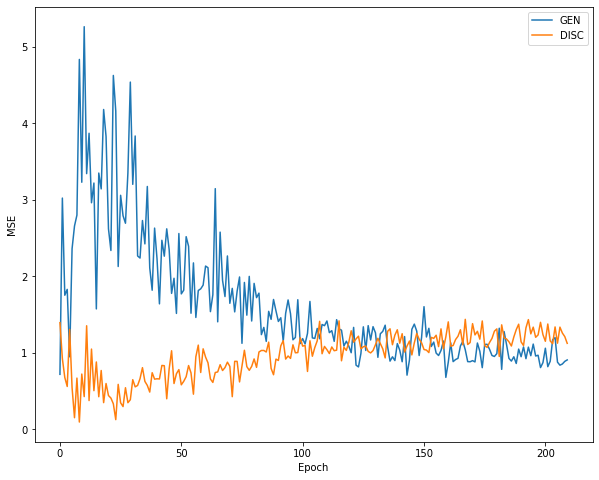

In [45]:
train_net(train_loader, g_optimizer, d_optimizer, num_epochs)

In [0]:
torch.save(generator.state_dict(), 'generator_state.pt')

### In this section we will test the generator printing all the numbers

In [0]:
z = Variable(torch.randn(100, 100)).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()

In [0]:
images = generator(z, labels).unsqueeze(1).cpu()

In [0]:
grid = utils.make_grid(images, nrow=10, normalize=True)

(-0.5, 301.5, 301.5, -0.5)

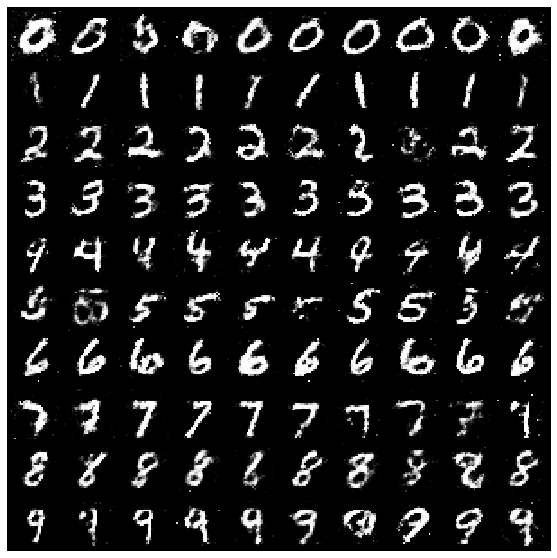

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).data, cmap='binary')
ax.axis('off')

In [0]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 100)).cuda()
    label = torch.LongTensor([digit]).cuda()
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

In [52]:
generate_digit(generator, 8)